#Section 1: Loading dataset

In [2]:
# Core Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics & EDA
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning - Preprocessing & Clustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# XGBoost
import xgboost as xgb

# Prophet
from prophet import Prophet

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)

# Reference date for time-based calculations
REFERENCE_DATE = pd.Timestamp("2015-01-01")

In [3]:
train = pd.read_csv(
    "train.csv",
    parse_dates=["Date"],
    low_memory=False
).set_index("Date")

print(f"Training data shape: {train.shape}")
print(f"Date range: {train.index.min()} to {train.index.max()}")

test = pd.read_csv(
    "test.csv",
    parse_dates=["Date"],
    low_memory=False
).set_index("Date")

print(f"Test data shape: {test.shape}")

store = pd.read_csv("store.csv", low_memory=False)

print(f"Store data shape: {store.shape}")
print(f"Number of stores: {store['Store'].nunique()}")

print("Training Data Sample")
display(train.head())

print("Store Data Sample")
display(store.head())

Training data shape: (1017209, 8)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Test data shape: (41088, 7)
Store data shape: (1115, 10)
Number of stores: 1115
Training Data Sample


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


Store Data Sample


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# EXPLORATORY DATA ANALYSIS (EDA)

Comprehensive exploration of the dataset to understand:
* Data types and structure
* Missing values
* Distribution of target variable (Sales)
* Time series patterns and seasonality
* Relationship between features

In [4]:
print("Descriptive Statistics")
train.describe().T

Descriptive Statistics


,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0


In [5]:
# Missing Value Analysis

print("Missing Values in Training Data")
print(train.isna().sum())

print("Missing Values in Store Data")
print(store.isna().sum())

Missing Values in Training Data
Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64
Missing Values in Store Data
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


**Observation**:
store dataset has missing values that needs to be imputed during feature engineering

Missing Features in store - 5 Features

CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear,  PromoInterval    

## **Target Variable Distribution Analysis**

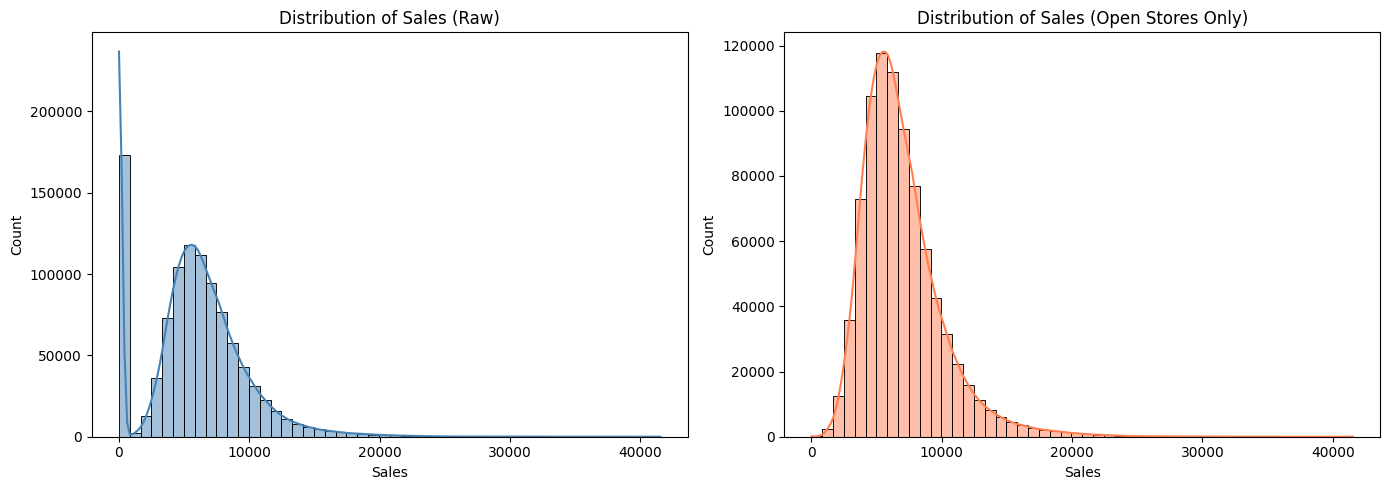

Sales Statistics (All data):
  Mean: 5,773.82
  Median: 5,744.00
  Std: 3,849.93
  Zero sales records: 172,871


In [6]:
# Target Variable Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw Sales Distribution
sns.histplot(train["Sales"], bins=50, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title("Distribution of Sales (Raw)")
axes[0].set_xlabel("Sales")

# Sales when store is open (excluding zeros)
open_sales = train[train["Open"] == 1]["Sales"]
sns.histplot(open_sales, bins=50, kde=True, ax=axes[1], color='coral')
axes[1].set_title("Distribution of Sales (Open Stores Only)")
axes[1].set_xlabel("Sales")

plt.tight_layout()
plt.show()

print(f"Sales Statistics (All data):")
print(f"  Mean: {train['Sales'].mean():,.2f}")
print(f"  Median: {train['Sales'].median():,.2f}")
print(f"  Std: {train['Sales'].std():,.2f}")
print(f"  Zero sales records: {(train['Sales'] == 0).sum():,}")

**Observation**

**Left plot — Distribution of Sales (Raw)**

* The huge spike at zero represents days when stores were closed.

* The rest of the distribution is right-skewed, with most sales between ~4k-10k and a long tail up to ~40k(which indicates some promo was running or super store).

* This mix of closed days + open days creates a bimodal-looking distribution.

**Right plot — Distribution of Sales (Open Stores Only)**

* After removing closed days, the distribution becomes smooth and unimodal.

* Sales cluster around a typical daily range (~5k-9k) with a long right tail for high-performing or promo days.

* This is the true demand pattern the model should learn for forecasting.

In [7]:
print("Zero Sales vs Store Open Status")
print(train.loc[train["Sales"] == 0, "Open"].value_counts())

Zero Sales vs Store Open Status
Open
0    172817
1        54
Name: count, dtype: int64


**Observation**

More 0 Sales was observed when store was closed (open=0)
Few 54 where 0 sales occured might be some exceptional case or some public event that some feature engineering or model can find pattern.

**Sales Per Customer Analysis (EDA Only - Leakage Risk)**

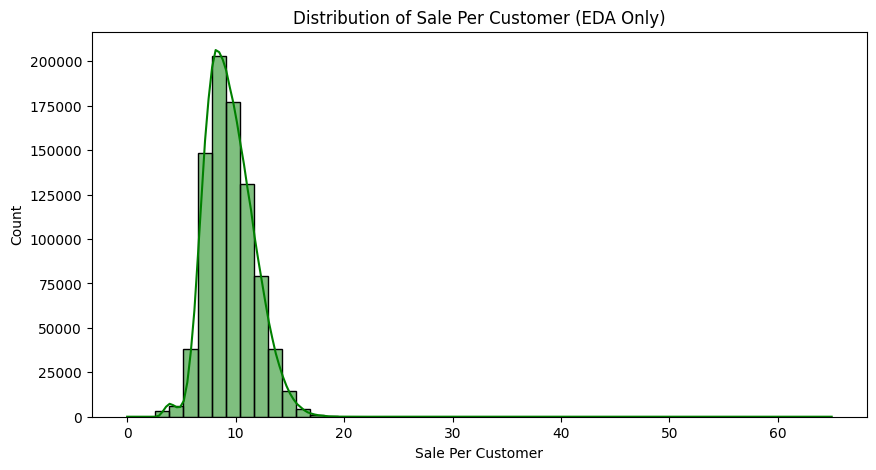

Sale Per Customer Statistics:
count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64


In [8]:
train["SalePerCustomer"] = train["Sales"] / train["Customers"].replace(0, np.nan)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(train["SalePerCustomer"].dropna(), bins=50, kde=True, color='green')
plt.title("Distribution of Sale Per Customer (EDA Only)")
plt.xlabel("Sale Per Customer")
plt.show()

print("Sale Per Customer Statistics:")
print(train["SalePerCustomer"].describe())

**Observation**

$$Sales=Customers * SalePerCustomer$$

* Total sales fluctuate mainly because the number of customers changes, not because customers spend very differently.
* Most days follow a similar spending pattern around the average, with only a few days where customers spend noticeably more or less than usual.

Sale for given day for a store can only be generated when the customer is known using above formula which means this cannot be used for modeling. Also capturing direct relationship with sales might cause data leakage.

## **Time Series Pattern Analysis (ACF/PACF)**

Autocorrelation analysis helps identify:

Seasonality patterns (weekly, monthly, yearly)
Appropriate lag features for models

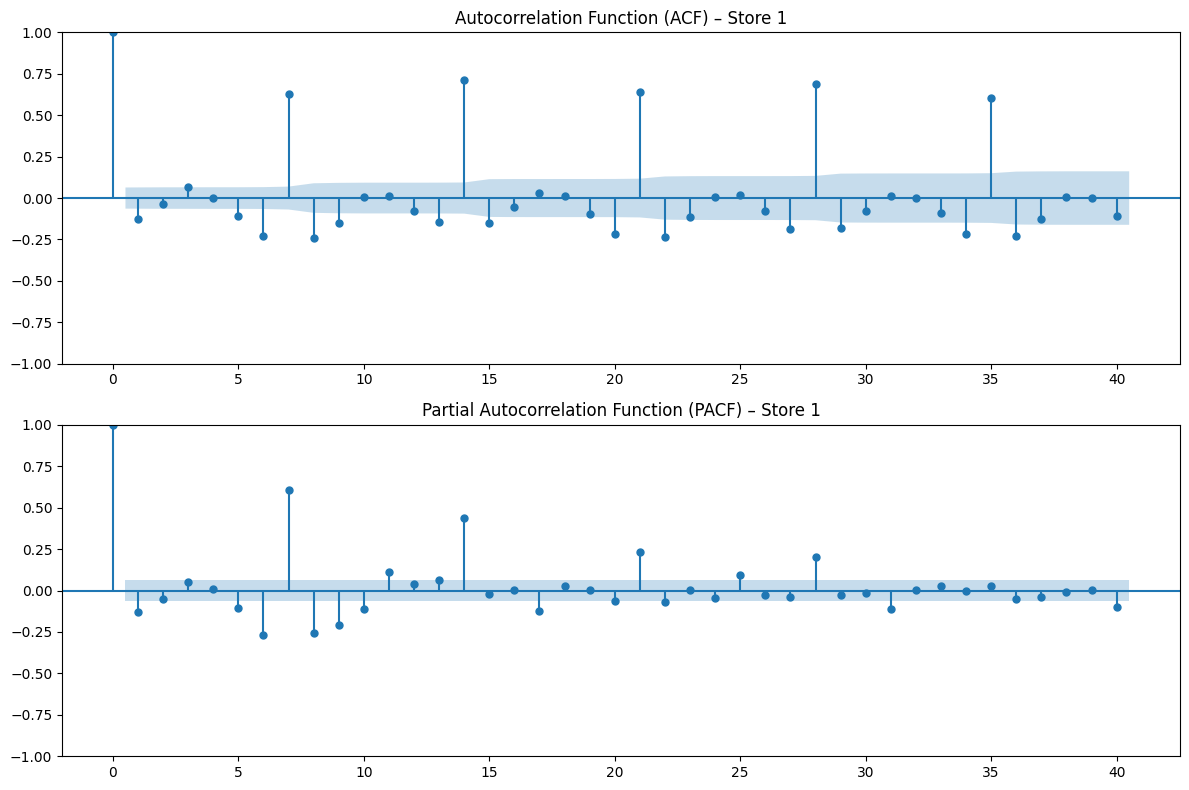

In [9]:
store_id = 1
series = train[train["Store"] == store_id].sort_index()["Sales"]

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF Plot
plot_acf(series, lags=40, ax=axes[0])
axes[0].set_title(f"Autocorrelation Function (ACF) – Store {store_id}")

# PACF Plot
plot_pacf(series, lags=40, method="ywm", ax=axes[1])
axes[1].set_title(f"Partial Autocorrelation Function (PACF) – Store {store_id}")

plt.tight_layout()
plt.show()

**Observation**

*ACF (top plot) — What repeats over time*

* There are strong spikes at lags 7, 14, 21, 28, 35.

* These spikes are well outside the confidence band, so they are statistically significant.

* It shows the dataset follows the weekly pattern as the sale today depends on the sales happened in last week, last to last week and the last to last to last week.

**PACF (bottom plot) — Which lags add new information**

* Smaller but still meaningful spikes appear at 14, 21, and 28.

* Most other lags are close to zero and inside the confidence band.

## Log Transformation Analysis

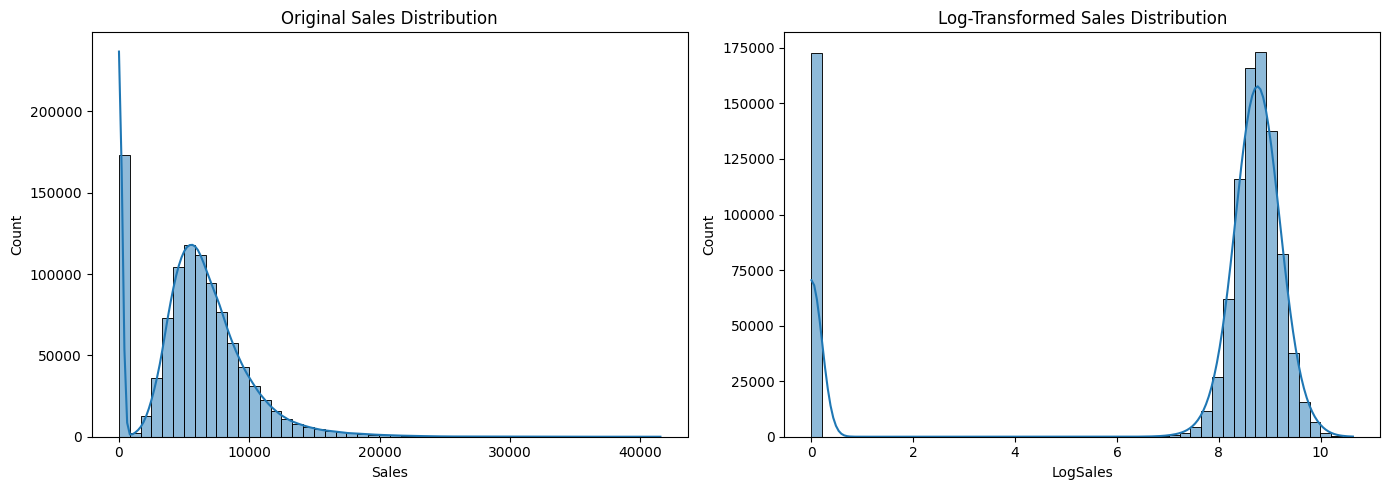

In [10]:
train["LogSales"] = np.log1p(train["Sales"])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(train["Sales"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Original Sales Distribution")

sns.histplot(train["LogSales"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Log-Transformed Sales Distribution")

plt.tight_layout()
plt.show()

**Observation**
* Log transformation makes distribution more normal.
* Need to consider the 0 sales



# Feature Engineering

Create meaningful features from the training data:

* Date-based features (temporal patterns)
* Holiday flags (business events)
* Lag features (historical sales patterns)
* Rolling statistics (trend indicators)

In [11]:
# Temporal features
train["Year"] = train.index.year
train["Month"] = train.index.month
train["Day"] = train.index.day
train["WeekOfYear"] = train.index.isocalendar().week.astype(int)
train["DayOfWeek"] = train.index.dayofweek

print("Date features created:")
display(train[["Year", "Month", "Day", "WeekOfYear", "DayOfWeek"]].head())

Date features created:


,Year,Month,Day,WeekOfYear,DayOfWeek
Date,,,,,
2015-07-31,2015,7,31,31,4
2015-07-31,2015,7,31,31,4
2015-07-31,2015,7,31,31,4
2015-07-31,2015,7,31,31,4
2015-07-31,2015,7,31,31,4


Holiday Feature Engineering

Convert categorical holiday indicators to binary flags.

StateHoliday has values: '0', 'a', 'b', 'c' (different holiday types)

One hot encoding here will increase dimensionality instead the binary encoding will help lstm/Transformer

In [17]:
train["StateHoliday"].value_counts()

,count
StateHoliday,
0,986159
a,20260
b,6690
c,4100


In [18]:
train["IsStateHoliday"] = train["StateHoliday"].apply(lambda x: 0 if x == "0" else 1)
train["IsSchoolHoliday"] = train["SchoolHoliday"].astype(int)

print("\nHoliday feature distribution:")
print(f"State Holidays: {train['IsStateHoliday'].sum():,} days")
print(f"School Holidays: {train['IsSchoolHoliday'].sum():,} days")


Holiday feature distribution:
State Holidays: 31,050 days
School Holidays: 181,721 days


Lag Features (Historical Sales Signals)

* shift(7) means using sales from 7 days ago
* Weekly lags (7, 14, 21, 28) capture weekly seasonality

In [20]:
lag_periods = [7, 14, 21, 28]

for lag in lag_periods:
    train[f"Sales_Lag_{lag}"] = train.groupby("Store")["Sales"].shift(lag)
    print(f"Created: Sales_Lag_{lag}")

Created: Sales_Lag_7
Created: Sales_Lag_14
Created: Sales_Lag_21
Created: Sales_Lag_28


Rolling Window Features (Trend Indicators)

* Rolling statistics smooth out noise and capture trends.
* shift(1) ensures we don't include current day's data (prevents leakage)

In [19]:
rolling_windows = [7, 14, 28]

for window in rolling_windows:
    train[f"Sales_Rolling_Mean_{window}"] = (
        train.groupby("Store")["Sales"]
        .shift(1)
        .rolling(window)
        .mean()
    )
    print(f"Created: Sales_Rolling_Mean_{window}")

Created: Sales_Rolling_Mean_7
Created: Sales_Rolling_Mean_14
Created: Sales_Rolling_Mean_28


**EDA-Only Feature: Lag of SalePerCustomer**

In [21]:
train["Lag_SalePerCustomer_7day"] = (
    train.groupby("Store")["SalePerCustomer"].shift(7)
)

print("Feature Engineering Complete")
train.head()

Feature Engineering Complete


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,LogSales,...,IsStateHoliday,IsSchoolHoliday,Sales_Rolling_Mean_7,Sales_Rolling_Mean_14,Sales_Rolling_Mean_28,Sales_Lag_7,Sales_Lag_14,Sales_Lag_21,Sales_Lag_28,Lag_SalePerCustomer_7day
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,9.482883,8.568646,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,2,4,6064,625,1,1,0,1,9.702400,8.710290,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,3,4,8314,821,1,1,0,1,10.126675,9.025816,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,4,4,13995,1498,1,1,0,1,9.342457,9.546527,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,5,4,4822,559,1,1,0,1,8.626118,8.481151,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## STORE METADATA PREPROCESSING

Process store.csv to create useful features:
- Competition information (distance, age)
- Promotion participation (Promo2)
- Handle missing values appropriately

These data are static data and don't show variability as per time series. These can be used as a fingerprint to model the store popularity, compitition from nearby stores, store runs promo or not. Later these can be used as a clustering to reduce the dimension and group similar stores for model predictions.

Without encoding this information the sales data(train.csv) is not sufficient and will miss store related patterns.

Missing CompetitionDistance: Assume very far (max value)
* Missing CompetitionOpenSince: Create flag for unknown
* Log-transform distance to reduce skewness

In [22]:
# Flag for stores with known competition
store["HasCompetition"] = store["CompetitionOpenSinceYear"].notna().astype(int)

# Handle missing competition distance (assume far away)
store["CompetitionDistance"] = store["CompetitionDistance"].fillna(
    store["CompetitionDistance"].max()
)
# Log transform to reduce skewness
store["CompetitionDistance"] = np.log1p(store["CompetitionDistance"])

# Handle missing competition dates
store["CompetitionOpenSinceMonth"] = store["CompetitionOpenSinceMonth"].fillna(1)
store["CompetitionOpenSinceYear"] = store["CompetitionOpenSinceYear"].fillna(
    REFERENCE_DATE.year
)

# Calculate competition age in months
store["CompetitionStart"] = pd.to_datetime(
    dict(
        year=store["CompetitionOpenSinceYear"],
        month=store["CompetitionOpenSinceMonth"],
        day=1
    )
)

store["CompetitionAgeMonths"] = (
    (REFERENCE_DATE - store["CompetitionStart"]) / np.timedelta64(1, "D")
) / 30.44

store["CompetitionAgeMonths"] = store["CompetitionAgeMonths"].clip(lower=0)

# Flag for unknown competition
store["CompetitionUnknown"] = (store["HasCompetition"] == 0).astype(int)

print("Competition features created:")
print(store[["Store", "CompetitionDistance", "CompetitionAgeMonths",
             "HasCompetition", "CompetitionUnknown"]].head())


Competition features created:
   Store  CompetitionDistance  CompetitionAgeMonths  HasCompetition  \
0      1             7.147559             75.985545               1   
1      2             6.347389             86.005256               1   
2      3             9.556126             97.010512               1   
3      4             6.431331             63.994744               1   
4      5            10.305982              0.000000               1   

   CompetitionUnknown  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  


**Promo2 Features**

Promo2 is a continuing promotion program:
* Promo2SinceWeek/Year: When store joined
* PromoInterval: Months when Promo2 is active


In [23]:
store["HasPromo2"] = store["Promo2"].astype(int)

# Handle missing promo dates
store["Promo2SinceWeek"] = store["Promo2SinceWeek"].fillna(1)
store["Promo2SinceYear"] = store["Promo2SinceYear"].fillna(2015)

# Calculate promo2 start date
store["Promo2Start"] = pd.to_datetime(
    store["Promo2SinceYear"].astype(int).astype(str)
    + "-W"
    + store["Promo2SinceWeek"].astype(int).astype(str)
    + "-1",
    format="%Y-W%W-%w"
)

# Calculate promo2 age in weeks
store["Promo2AgeWeeks"] = (
    (REFERENCE_DATE - store["Promo2Start"]) / np.timedelta64(1, "W")
).clip(lower=0)

# Flag for promo interval availability
store["HasPromoInterval"] = store["PromoInterval"].notna().astype(int)

print("\nPromo2 features created:")
print(store[["Store", "HasPromo2", "Promo2AgeWeeks", "HasPromoInterval"]].head())

# Verify no missing values in key columns
print("Missing Values After Preprocessing")
print(store[["CompetitionDistance", "CompetitionAgeMonths",
             "HasPromo2", "Promo2AgeWeeks"]].isna().sum())


Promo2 features created:
   Store  HasPromo2  Promo2AgeWeeks  HasPromoInterval
0      1          0        0.000000                 0
1      2          1      248.428571                 1
2      3          1      195.428571                 1
3      4          0        0.000000                 0
4      5          0        0.000000                 0
Missing Values After Preprocessing
CompetitionDistance     0
CompetitionAgeMonths    0
HasPromo2               0
Promo2AgeWeeks          0
dtype: int64


 **STORE CLUSTERING**

Cluster stores based on their characteristics to:
- Capture store-level behavior patterns
- Reduce dimensionality of store features
- Enable cluster-specific modeling approaches

In [24]:
store_feat = store.copy()

# One-hot encode categorical variables
store_cat = pd.get_dummies(
    store_feat[["StoreType", "Assortment"]],
    drop_first=True
)

# Combine with numerical features
cluster_features = pd.concat(
    [
        store_cat,
        store_feat[
            [
                "CompetitionDistance",
                "CompetitionAgeMonths",
                "CompetitionUnknown",
                "HasPromo2",
                "HasPromoInterval"
            ]
        ]
    ],
    axis=1
)

print("Clustering features shape:", cluster_features.shape)
print("Features used:", cluster_features.columns.tolist())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_features)

Clustering features shape: (1115, 10)
Features used: ['StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c', 'CompetitionDistance', 'CompetitionAgeMonths', 'CompetitionUnknown', 'HasPromo2', 'HasPromoInterval']


Elbow Method for Optimal K

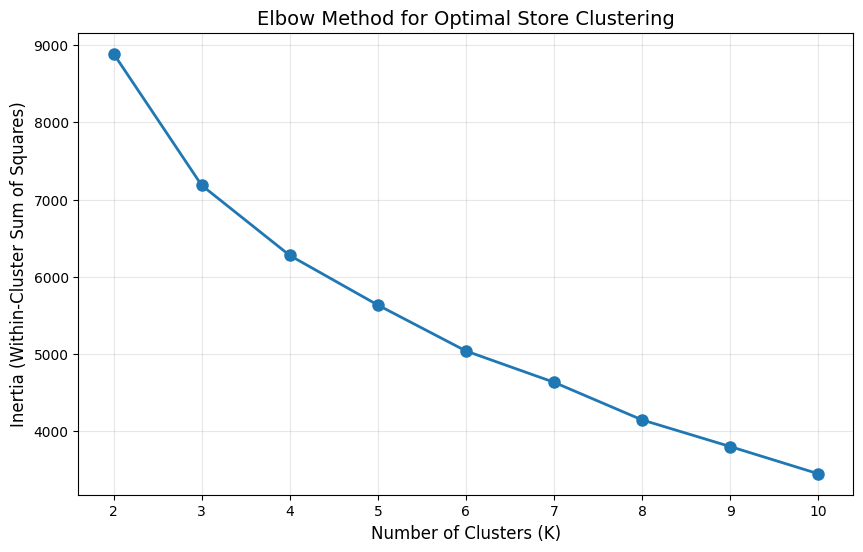

In [25]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker="o", linewidth=2, markersize=8)
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Inertia (Within-Cluster Sum of Squares)", fontsize=12)
plt.title("Elbow Method for Optimal Store Clustering", fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.show()

**Observation**

Elbow appears around K=4

In [26]:
OPTIMAL_K = 4

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
store_feat["StoreCluster"] = kmeans.fit_predict(X_scaled)

print(f"\nStore Cluster Distribution (K={OPTIMAL_K}):")
print(store_feat["StoreCluster"].value_counts().sort_index())

# Visualize cluster characteristics
cluster_summary = store_feat.groupby("StoreCluster").agg({
    "CompetitionDistance": "mean",
    "HasPromo2": "mean",
    "Store": "count"
}).rename(columns={"Store": "StoreCount"})

print("\nCluster Summary:")
display(cluster_summary)


Store Cluster Distribution (K=4):
StoreCluster
0    148
1    492
2    466
3      9
Name: count, dtype: int64

Cluster Summary:


,CompetitionDistance,HasPromo2,StoreCount
StoreCluster,,,
0,7.284308,0.506757,148
1,7.551639,1.000000,492
2,7.898363,0.000000,466
3,6.814300,0.444444,9


## Merge Cluster with training data

In [27]:
train_reset = train.reset_index()

train = (
    train_reset
    .merge(
        store_feat[["Store", "StoreCluster"]],
        on="Store",
        how="left"
    )
    .set_index("Date")
)

print("Training Data with Store Clusters")
display(train.head())
print(f"Final training data shape: {train.shape}")

Training Data with Store Clusters


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalePerCustomer,LogSales,...,IsSchoolHoliday,Sales_Rolling_Mean_7,Sales_Rolling_Mean_14,Sales_Rolling_Mean_28,Sales_Lag_7,Sales_Lag_14,Sales_Lag_21,Sales_Lag_28,Lag_SalePerCustomer_7day,StoreCluster
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,9.482883,8.568646,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-07-31,2,4,6064,625,1,1,0,1,9.702400,8.710290,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2015-07-31,3,4,8314,821,1,1,0,1,10.126675,9.025816,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2015-07-31,4,4,13995,1498,1,1,0,1,9.342457,9.546527,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2015-07-31,5,4,4822,559,1,1,0,1,8.626118,8.481151,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


Final training data shape: (1017209, 25)


In [28]:
# Save training data
train.to_csv("train_with_clusters.csv", index=True)

# Save clustering metrics
cluster_summary.to_csv("cluster_metrics.csv", index=True)